# 🌞 MoonLight Energy Solutions: Solar Investment Analysis — Togo 🇹🇬

In [1]:
#all imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
sys.path.append('../scripts')
import warnings
from scipy.stats import zscore
from data_quality_utils import columns_with_significant_missing_values,detect_outliers_zscore,find_columns_with_invalid_values, conditional_impute,impute_multiple_targets_with_model,impute_ghi_with_linear_regression,replace_negative_irradiance_with_nan,get_outlier_counts
from visualization_utils import plot_continuous_histograms, plot_scatter_relationships,plot_rh_relationships,plot_bubble_ghi_vs_tamb,plot_mod_cleaning_effect,plot_irradiance_temperature_timeseries,plot_hourly_irradiance_temperature, plot_monthly_irradiance_temperature,plot_ghi_anomalies,plot_wind_rose,plot_correlation_heatmap,plot_pairplot,plot_outlier_stripplots,plot_outlier_boxplots,filter_daytime
from feature_engineering_utils import log_transform_columns
from windrose import WindroseAxes

In [2]:
#suppress all warnings
warnings.filterwarnings("ignore")

## 📚 Table of Contents

1. [📊 Introduction & Objective](#1-introduction--objective)
2. [📦 Data Loading & Overview](#2-data-loading--overview)
3. [📐 Data Types & Basic Stats](#3-data-types--basic-stats)
4. [🔍 Data Quality Analysis](#4-data-quality-analysis)
5. [🧹 Data Cleaning](#5-data-cleaning)
6. [📈 Univariate Analysis (Single Variable)](#6-univariate-analysis-single-variable)
7. [📉 Bivariate/Multivariate Analysis](#7-bivariatemultivariate-analysis)
8. [🧮 Feature Engineering](#8-feature-engineering)
9. [📅 Time Series Trends](#9-time-series-trends)
10. [🧠 Key Insights](#10-key-insights)
11. [🔚 Conclusion & Next Steps](#11-conclusion--next-steps)

## 📊 1. Introduction & Objective <a id='#1-introduction--objective'></a>

### Background in the Subject Matter

Understanding lead and lag measures is crucial in solar energy analytics to identify what drives performance (lead) and what reflects performance outcomes (lag).

---

#### 🔹 Lead Measures

| Parameter         | Description |
|------------------|-------------|
| **Cleaning (1/0)** | Indicates whether a cleaning event occurred. A direct action that can influence panel efficiency. |
| **Precipitation (mm/min)** | Natural cleaning mechanism. Affects panel cleanliness and performance. |
| **RH (Relative Humidity)** | Can contribute to soiling or panel fogging. A predictive factor for efficiency. |
| **WS (Wind Speed)** | Can help remove dust/debris. High wind may act as a natural cleaning factor. |
| **TModA / TModB (°C)** | Module temperatures. Impact the conversion efficiency — monitored to optimize performance. |



#### 🔹 Lag Measures

| Parameter         | Description |
|------------------|-------------|
| **GHI (Global Horizontal Irradiance)** | Total solar radiation on a horizontal surface — reflects solar availability. |
| **DNI (Direct Normal Irradiance)** | Direct solar radiation received perpendicularly — outcome of atmospheric conditions. |
| **DHI (Diffuse Horizontal Irradiance)** | Scattered sunlight received — indicates sky clarity. |
| **ModA / ModB (W/m²)** | Actual power received by panels — outcome of environmental and maintenance factors. |
| **Tamb (Ambient Temperature)** | Environmental factor — affects efficiency but cannot be controlled. |
| **BP (Barometric Pressure)** | Reflects atmospheric conditions — no direct control. |
| **WD / WDstdev** | Wind direction and its variability — background environmental effects. |
| **WSstdev / WSgust** | Wind variability and gusts — lag indicators of natural impacts. |



###  🇹🇬 Background on Togo

#### ☀️ Solar Power Potential of Togo
Togo, located in West Africa between latitudes 6° and 11° North of the Equator, possesses considerable untapped solar energy potential. With average Global Horizontal Irradiance (GHI) levels ranging from 4.5 to 5.8 kWh/m²/day, the country enjoys consistent and abundant sunlight year-round. This makes Togo particularly well-suited for solar photovoltaic (PV) energy generation, especially in rural and off-grid areas where access to electricity remains limited. Its geographical position, combined with varied terrain and rising energy needs, positions Togo as a strategic location for scalable solar energy investments. 

### 🎯 Business Objective

- Perform a quick yet insightful analysis of solar radiation and environmental data to:
- Identify **key trends and performance drivers**.
- Understand the **impact of environmental conditions** on solar energy potential.
- Evaluate the **effect of soiling and cleaning** on solar module performance.
- Recommend **ideal conditions or locations** for sustainable solar installations.


### 🧠 Key Questions to Explore

1. **Solar Potential**  
   - Where and when is solar radiation (`GHI`, `DNI`, `DHI`) strongest and most consistent?

2. **Environmental Impact on Performance**  
   - How do temperature, humidity, wind, and pressure affect solar metrics?

3. **Sensor/Module Performance**  
   - How do `ModA` and `ModB` correlate with irradiance data?
   - Are performance improvements observed after cleaning?

4. **Cleaning Effectiveness**  
   - What is the impact of cleaning events on solar performance?
   - Can a cleaning schedule be recommended?

## 📦 2. Data Loading & Overview  <a id= '2-data-loading--overview'></a>

#### Loading Data

In [3]:
#load the data from the github repo or #using locally stored dataset
df=pd.read_csv('../data/togo-dapaong_qc.csv')
df

,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
0,2021-10-25 00:01,-1.3,0.0,0.0,0.0,0.0,24.8,94.5,0.9,1.1,0.4,227.6,1.1,977,0,0.0,24.7,24.4,NaN
1,2021-10-25 00:02,-1.3,0.0,0.0,0.0,0.0,24.8,94.4,1.1,1.6,0.4,229.3,0.7,977,0,0.0,24.7,24.4,NaN
2,2021-10-25 00:03,-1.3,0.0,0.0,0.0,0.0,24.8,94.4,1.2,1.4,0.3,228.5,2.9,977,0,0.0,24.7,24.4,NaN
3,2021-10-25 00:04,-1.2,0.0,0.0,0.0,0.0,24.8,94.3,1.2,1.6,0.3,229.1,4.6,977,0,0.0,24.7,24.4,NaN
4,2021-10-25 00:05,-1.2,0.0,0.0,0.0,0.0,24.8,94.0,1.3,1.6,0.4,227.5,1.6,977,0,0.0,24.7,24.4,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525595,2022-10-24 23:56,-0.8,0.0,0.0,0.0,0.0,25.2,53.8,0.0,0.0,0.0,0.0,0.0,977,0,0.0,24.3,24.0,NaN
525596,2022-10-24 23:57,-0.9,0.0,0.0,0.0,0.0,25.3,53.5,0.0,0.0,0.0,0.0,0.0,977,0,0.0,24.3,24.0,NaN
525597,2022-10-24 23:58,-1.0,0.0,0.0,0.0,0.0,25.3,53.4,0.0,0.0,0.0,0.0,0.0,977,0,0.0,24.2,23.9,NaN
525598,2022-10-24 23:59,-1.1,0.0,0.0,0.0,0.0,25.4,53.5,0.0,0.0,0.0,0.0,0.0,977,0,0.0,24.1,23.8,NaN


#### Data Overview

In [4]:
df.head()

,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
0,2021-10-25 00:01,-1.3,0.0,0.0,0.0,0.0,24.8,94.5,0.9,1.1,0.4,227.6,1.1,977,0,0.0,24.7,24.4,NaN
1,2021-10-25 00:02,-1.3,0.0,0.0,0.0,0.0,24.8,94.4,1.1,1.6,0.4,229.3,0.7,977,0,0.0,24.7,24.4,NaN
2,2021-10-25 00:03,-1.3,0.0,0.0,0.0,0.0,24.8,94.4,1.2,1.4,0.3,228.5,2.9,977,0,0.0,24.7,24.4,NaN
3,2021-10-25 00:04,-1.2,0.0,0.0,0.0,0.0,24.8,94.3,1.2,1.6,0.3,229.1,4.6,977,0,0.0,24.7,24.4,NaN
4,2021-10-25 00:05,-1.2,0.0,0.0,0.0,0.0,24.8,94.0,1.3,1.6,0.4,227.5,1.6,977,0,0.0,24.7,24.4,NaN


In [5]:
df.tail()

,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
525595,2022-10-24 23:56,-0.8,0.0,0.0,0.0,0.0,25.2,53.8,0.0,0.0,0.0,0.0,0.0,977,0,0.0,24.3,24.0,NaN
525596,2022-10-24 23:57,-0.9,0.0,0.0,0.0,0.0,25.3,53.5,0.0,0.0,0.0,0.0,0.0,977,0,0.0,24.3,24.0,NaN
525597,2022-10-24 23:58,-1.0,0.0,0.0,0.0,0.0,25.3,53.4,0.0,0.0,0.0,0.0,0.0,977,0,0.0,24.2,23.9,NaN
525598,2022-10-24 23:59,-1.1,0.0,0.0,0.0,0.0,25.4,53.5,0.0,0.0,0.0,0.0,0.0,977,0,0.0,24.1,23.8,NaN
525599,2022-10-25 00:00,-1.2,0.0,0.0,0.0,0.0,25.4,52.3,0.0,0.0,0.0,0.0,0.0,977,0,0.0,24.1,23.8,NaN


In [6]:
df.sample(10)

,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
445583,2022-08-30 10:24,451.9,7.0,443.7,429.0,424.2,27.2,73.7,1.6,2.1,0.4,10.9,12.9,978,0,0.0,37.8,43.2,NaN
466746,2022-09-14 03:07,-1.2,0.0,0.0,0.0,0.0,23.0,98.3,1.6,1.9,0.4,244.2,1.7,976,0,0.0,22.7,22.4,NaN
95216,2021-12-30 02:57,-3.3,0.0,0.0,0.0,0.0,19.0,29.2,1.9,2.4,0.3,79.7,6.7,977,0,0.0,16.9,16.6,NaN
314975,2022-05-31 17:36,69.6,0.0,66.2,63.7,63.0,32.5,58.0,0.7,1.9,0.7,195.0,11.0,973,0,0.0,34.6,34.8,NaN
480658,2022-09-23 18:59,-0.2,0.0,0.0,0.0,0.0,23.2,91.1,0.1,0.7,0.3,25.2,0.1,975,0,0.0,23.3,23.2,NaN
383968,2022-07-18 15:29,686.0,397.5,405.1,596.2,592.5,28.2,75.6,4.3,5.2,0.6,222.4,11.5,976,0,0.0,37.5,37.5,NaN
40312,2021-11-21 23:53,-2.7,0.0,0.0,0.0,0.0,24.7,35.4,0.1,0.7,0.2,66.2,0.3,975,0,0.0,22.0,21.4,NaN
375747,2022-07-12 22:28,-2.2,0.0,0.0,0.0,0.0,27.9,71.0,1.6,2.4,0.5,217.7,9.7,979,0,0.0,27.2,26.8,NaN
139796,2022-01-30 01:57,-3.5,0.0,0.0,0.0,0.0,22.2,18.2,3.3,4.4,0.6,58.5,9.5,978,0,0.0,21.4,20.9,NaN
484928,2022-09-26 18:09,-2.2,0.0,0.0,0.1,0.1,23.4,93.1,0.0,0.0,0.0,0.0,0.0,976,0,0.0,22.7,22.6,NaN


In [7]:
#shape of the dataset
df.shape

(525600, 19)

In [8]:
#list of columns of the dataset
df.columns

Index(['Timestamp', 'GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'Tamb', 'RH', 'WS',
       'WSgust', 'WSstdev', 'WD', 'WDstdev', 'BP', 'Cleaning', 'Precipitation',
       'TModA', 'TModB', 'Comments'],
      dtype='object')

## 📐 3. Data Types & Basic Stats <a id='3-data-types--basic-stats'></a>

#### Data Summaries - basics stats

In [9]:
#Numerical Columns
df.describe().T

,count,mean,std,min,25%,50%,75%,max
GHI,525600.0,230.555040,322.532347,-12.7,-2.2,2.1,442.400,1424.0
DNI,525600.0,151.258469,250.956962,0.0,0.0,0.0,246.400,1004.5
DHI,525600.0,116.444352,156.520714,0.0,0.0,2.5,215.700,805.7
ModA,525600.0,226.144375,317.346938,0.0,0.0,4.4,422.525,1380.0
ModB,525600.0,219.568588,307.932510,0.0,0.0,4.3,411.000,1367.0
Tamb,525600.0,27.751788,4.758023,14.9,24.2,27.2,31.100,41.4
RH,525600.0,55.013160,28.778732,3.3,26.5,59.3,80.800,99.8
WS,525600.0,2.368093,1.462668,0.0,1.4,2.2,3.200,16.1
WSgust,525600.0,3.229490,1.882565,0.0,1.9,2.9,4.400,23.1
WSstdev,525600.0,0.557740,0.268923,0.0,0.4,0.5,0.700,4.7


In [10]:
#for columns of object type
df.describe(include=['O']).T

,count,unique,top,freq
Timestamp,525600,525600,2022-10-24 23:44,1


#### Data Types

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525600 entries, 0 to 525599
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Timestamp      525600 non-null  object 
 1   GHI            525600 non-null  float64
 2   DNI            525600 non-null  float64
 3   DHI            525600 non-null  float64
 4   ModA           525600 non-null  float64
 5   ModB           525600 non-null  float64
 6   Tamb           525600 non-null  float64
 7   RH             525600 non-null  float64
 8   WS             525600 non-null  float64
 9   WSgust         525600 non-null  float64
 10  WSstdev        525600 non-null  float64
 11  WD             525600 non-null  float64
 12  WDstdev        525600 non-null  float64
 13  BP             525600 non-null  int64  
 14  Cleaning       525600 non-null  int64  
 15  Precipitation  525600 non-null  float64
 16  TModA          525600 non-null  float64
 17  TModB          525600 non-nul

### Distinct Values

In [13]:
df.nunique().sort_values(ascending=False)

Timestamp        525600
ModA              10672
DNI                9612
GHI                8633
ModB               8439
DHI                6841
WD                 3601
RH                  966
TModB               769
WDstdev             614
TModA               564
Tamb                266
WSgust              156
WS                  143
WSstdev              44
Precipitation        22
BP                   16
Cleaning              2
Comments              0
dtype: int64

## 🔍 4. Data Quality Analysis <a id='4-data-quality-analysis'></a>

### Missing-Values Analysis

In [14]:
#count of missing values per column
df.isna().sum() 

Timestamp             0
GHI                   0
DNI                   0
DHI                   0
ModA                  0
ModB                  0
Tamb                  0
RH                    0
WS                    0
WSgust                0
WSstdev               0
WD                    0
WDstdev               0
BP                    0
Cleaning              0
Precipitation         0
TModA                 0
TModB                 0
Comments         525600
dtype: int64

##### Columns with significant number of missing values

In [17]:
#column with >5% nulls
columns_with_significant_missing_values(df, threshold=5)

,#missing_values,percentage
Comments,525600,100.00%


### Duplicated Values Analysis

In [18]:
#check for duplicates
print(df.duplicated().sum())

0


### Detect Invalid Data

#### Check if data lies within the valid range

In [19]:
# Dictionary of variable name and valid range (min, max)
valid_ranges = {
    'GHI': (0, 1300),
    'DNI': (0, 1300),
    'DHI': (0, 1000),
    'ModA': (0, 1300),
    'ModB': (0, 1300),
    'Tamb': (-40, 60),
    'TModA': (-40, 80),
    'TModB': (-40, 80),
    'RH': (0, 100),
    'WS': (0, 60),
    'WSgust': (0, 80),
    'WSstdev': (0, 20),
    'WD': (0, 360),
    'WDstdev': (0, 180),
    'BP': (800, 1100),
    'Precipitation': (0, 10),
    'Cleaning': (0, 1)
}


In [20]:
# Find columns that violate the valid ranges
find_columns_with_invalid_values(df,valid_ranges)

{'GHI': ['< 0', '> 1300'],
 'ModA': ['> 1300'],
 'ModB': ['> 1300'],
 'TModB': ['> 80']}

##### Looking into Negative Irradiance values

In [21]:
# Count rows where any of the three values is negative
invalid_rows = df[(df['GHI'] < 0) | (df['DHI'] < 0) | (df['DNI'] < 0)]

# Print count
print(f"Rows with at least one invalid irradiance value (GHI, DHI, or DNI < 0): {len(invalid_rows)}")


Rows with at least one invalid irradiance value (GHI, DHI, or DNI < 0): 257385


##### Check if these negative values for GHI,DNI and DHI occur simultaneously

In [22]:
# Create a boolean mask for each condition
neg_ghi = df['GHI'] < 0
neg_dhi = df['DHI'] < 0
neg_dni = df['DNI'] < 0

# Create a new column to capture the combination as a label
df['irradiance_negative_combo'] = (
    neg_ghi.astype(int).astype(str) + 
    neg_dhi.astype(int).astype(str) + 
    neg_dni.astype(int).astype(str)
)

# Count frequency of each combination
combo_counts = df['irradiance_negative_combo'].value_counts().sort_index()
print(combo_counts)


irradiance_negative_combo
000    268215
100    257385
Name: count, dtype: int64


##### Check if this negative values are recorded during the night -- to see if we can impute 0 as their value

In [23]:
#add hour and is_night columns to help with analysis
df['hour'] = pd.to_datetime(df['Timestamp']).dt.hour
df['is_night'] = (df['hour'] < 6) | (df['hour'] > 18)  # Example: night before 6 AM or after 6 PM
df


,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,...,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments,irradiance_negative_combo,hour,is_night
0,2021-10-25 00:01,-1.3,0.0,0.0,0.0,0.0,24.8,94.5,0.9,1.1,...,1.1,977,0,0.0,24.7,24.4,NaN,100,0,True
1,2021-10-25 00:02,-1.3,0.0,0.0,0.0,0.0,24.8,94.4,1.1,1.6,...,0.7,977,0,0.0,24.7,24.4,NaN,100,0,True
2,2021-10-25 00:03,-1.3,0.0,0.0,0.0,0.0,24.8,94.4,1.2,1.4,...,2.9,977,0,0.0,24.7,24.4,NaN,100,0,True
3,2021-10-25 00:04,-1.2,0.0,0.0,0.0,0.0,24.8,94.3,1.2,1.6,...,4.6,977,0,0.0,24.7,24.4,NaN,100,0,True
4,2021-10-25 00:05,-1.2,0.0,0.0,0.0,0.0,24.8,94.0,1.3,1.6,...,1.6,977,0,0.0,24.7,24.4,NaN,100,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525595,2022-10-24 23:56,-0.8,0.0,0.0,0.0,0.0,25.2,53.8,0.0,0.0,...,0.0,977,0,0.0,24.3,24.0,NaN,100,23,True
525596,2022-10-24 23:57,-0.9,0.0,0.0,0.0,0.0,25.3,53.5,0.0,0.0,...,0.0,977,0,0.0,24.3,24.0,NaN,100,23,True
525597,2022-10-24 23:58,-1.0,0.0,0.0,0.0,0.0,25.3,53.4,0.0,0.0,...,0.0,977,0,0.0,24.2,23.9,NaN,100,23,True
525598,2022-10-24 23:59,-1.1,0.0,0.0,0.0,0.0,25.4,53.5,0.0,0.0,...,0.0,977,0,0.0,24.1,23.8,NaN,100,23,True


In [24]:
# Filter rows where GHI, DNI, DHI < 0
irradiance_neg = df[(df['GHI'] < 0) | (df['DNI'] < 0) | (df['DHI'] < 0)]

# Check how many of those rows occurred at night
irradiance_neg['is_night'].value_counts()


is_night
True     235367
False     22018
Name: count, dtype: int64

##### Negative GHI,DNI,DHI values happening simaltaneously during the night - > candidates to be imputed as zero

In [25]:
# Group by combo and night/day
combo_night_counts = df.groupby(['irradiance_negative_combo', 'is_night']).size().unstack(fill_value=0)

# Rename columns for clarity
combo_night_counts.columns = ['day_count', 'night_count']  # False → Day, True → Night

# Optional: Add total count per combo
combo_night_counts['total'] = combo_night_counts['day_count'] + combo_night_counts['night_count']

# Display the result
print(combo_night_counts)


                           day_count  night_count   total
irradiance_negative_combo                                
000                           262682         5533  268215
100                            22018       235367  257385


<div style="border-radius:10px; border:orange solid; padding: 15px; font-size:100%; text-align:left; font-color:#325939;background-color:#2c2c2c">
<h3 align="left"><font color='orange'>💡 Course of Action:</font></h3>

We only have negative values for GHI - we can impute it from the module readings.

##### Exploring Irradiance values beyond 1300

In [26]:
# Filter rows where GHI or DNI are greater than 1300
high_irradiance_df = df[(df['GHI'] > 1300) | (df['ModA'] > 1300)| (df['ModB'] > 1300)]

# Display the filtered rows
print(high_irradiance_df)

# Optionally, see how many such rows exist
print(f"Number of rows with ModA or ModB> 1300: {len(high_irradiance_df)}")


               Timestamp     GHI    DNI    DHI    ModA    ModB  Tamb    RH  \
269959  2022-04-30 11:20  1301.0  733.9  562.1  1195.0  1178.0  31.0  54.5   
269962  2022-04-30 11:23  1306.0  757.1  548.0  1206.0  1189.0  31.3  53.0   
340531  2022-06-18 11:32  1391.0  688.6  699.0  1251.0  1236.0  26.5  80.5   
382441  2022-07-17 14:02  1328.0  829.3  592.9  1193.0  1183.0  26.3  82.5   
385171  2022-07-19 11:32  1304.0  754.4  547.3  1173.0  1158.0  28.5  70.1   
385172  2022-07-19 11:33  1367.0  823.7  550.9  1237.0  1222.0  28.4  70.1   
406818  2022-08-03 12:19  1385.0  826.2  550.5  1276.0  1262.0  28.2  72.2   
406834  2022-08-03 12:35  1325.0  780.6  531.0  1214.0  1200.0  29.0  70.2   
406846  2022-08-03 12:47  1320.0  716.3  589.4  1210.0  1198.0  29.2  68.9   
409719  2022-08-05 12:40  1324.0  722.8  604.5  1243.0  1230.0  27.9  71.5   
411122  2022-08-06 12:03  1362.0  797.1  548.6  1252.0  1242.0  28.7  65.5   
411174  2022-08-06 12:55  1301.0  802.1  498.7  1191.0  1181.0  

<div style="border-radius:10px; border:orange solid; padding: 15px; font-size:100%; text-align:left; font-color:#325939;background-color:#2c2c2c">
<h3 align="left"><font color='orange'>💡 Observations:</font></h3>
🔍 Observations: 

- These high GHI values mostly occur between 11:00 and 14:00, aligning with peak solar noon.

- High Direct Normal Irradiance (DNI) values (up to 861.8 W/m²) suggest clear-sky conditions with minimal cloud cover during those times.
</dv>



In [27]:
# Drop flags and timestamp columns
df.drop(columns=['irradiance_negative_combo', 'hour', 'is_night'], inplace=True)
df

,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
0,2021-10-25 00:01,-1.3,0.0,0.0,0.0,0.0,24.8,94.5,0.9,1.1,0.4,227.6,1.1,977,0,0.0,24.7,24.4,NaN
1,2021-10-25 00:02,-1.3,0.0,0.0,0.0,0.0,24.8,94.4,1.1,1.6,0.4,229.3,0.7,977,0,0.0,24.7,24.4,NaN
2,2021-10-25 00:03,-1.3,0.0,0.0,0.0,0.0,24.8,94.4,1.2,1.4,0.3,228.5,2.9,977,0,0.0,24.7,24.4,NaN
3,2021-10-25 00:04,-1.2,0.0,0.0,0.0,0.0,24.8,94.3,1.2,1.6,0.3,229.1,4.6,977,0,0.0,24.7,24.4,NaN
4,2021-10-25 00:05,-1.2,0.0,0.0,0.0,0.0,24.8,94.0,1.3,1.6,0.4,227.5,1.6,977,0,0.0,24.7,24.4,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525595,2022-10-24 23:56,-0.8,0.0,0.0,0.0,0.0,25.2,53.8,0.0,0.0,0.0,0.0,0.0,977,0,0.0,24.3,24.0,NaN
525596,2022-10-24 23:57,-0.9,0.0,0.0,0.0,0.0,25.3,53.5,0.0,0.0,0.0,0.0,0.0,977,0,0.0,24.3,24.0,NaN
525597,2022-10-24 23:58,-1.0,0.0,0.0,0.0,0.0,25.3,53.4,0.0,0.0,0.0,0.0,0.0,977,0,0.0,24.2,23.9,NaN
525598,2022-10-24 23:59,-1.1,0.0,0.0,0.0,0.0,25.4,53.5,0.0,0.0,0.0,0.0,0.0,977,0,0.0,24.1,23.8,NaN


### Outlier Detection

#### Detect outliers

In [28]:
columns_to_check_for_outliers = ['ModA','ModB','WS','WSgust','GHI','DHI','DNI']
outlier_df =(df, columns_to_check_for_outliers)
print(outlier_df)

(               Timestamp  GHI  DNI  DHI  ModA  ModB  Tamb    RH   WS  WSgust  \
0       2021-10-25 00:01 -1.3  0.0  0.0   0.0   0.0  24.8  94.5  0.9     1.1   
1       2021-10-25 00:02 -1.3  0.0  0.0   0.0   0.0  24.8  94.4  1.1     1.6   
2       2021-10-25 00:03 -1.3  0.0  0.0   0.0   0.0  24.8  94.4  1.2     1.4   
3       2021-10-25 00:04 -1.2  0.0  0.0   0.0   0.0  24.8  94.3  1.2     1.6   
4       2021-10-25 00:05 -1.2  0.0  0.0   0.0   0.0  24.8  94.0  1.3     1.6   
...                  ...  ...  ...  ...   ...   ...   ...   ...  ...     ...   
525595  2022-10-24 23:56 -0.8  0.0  0.0   0.0   0.0  25.2  53.8  0.0     0.0   
525596  2022-10-24 23:57 -0.9  0.0  0.0   0.0   0.0  25.3  53.5  0.0     0.0   
525597  2022-10-24 23:58 -1.0  0.0  0.0   0.0   0.0  25.3  53.4  0.0     0.0   
525598  2022-10-24 23:59 -1.1  0.0  0.0   0.0   0.0  25.4  53.5  0.0     0.0   
525599  2022-10-25 00:00 -1.2  0.0  0.0   0.0   0.0  25.4  52.3  0.0     0.0   

        WSstdev     WD  WDstdev   BP  

#### Visualize outliers

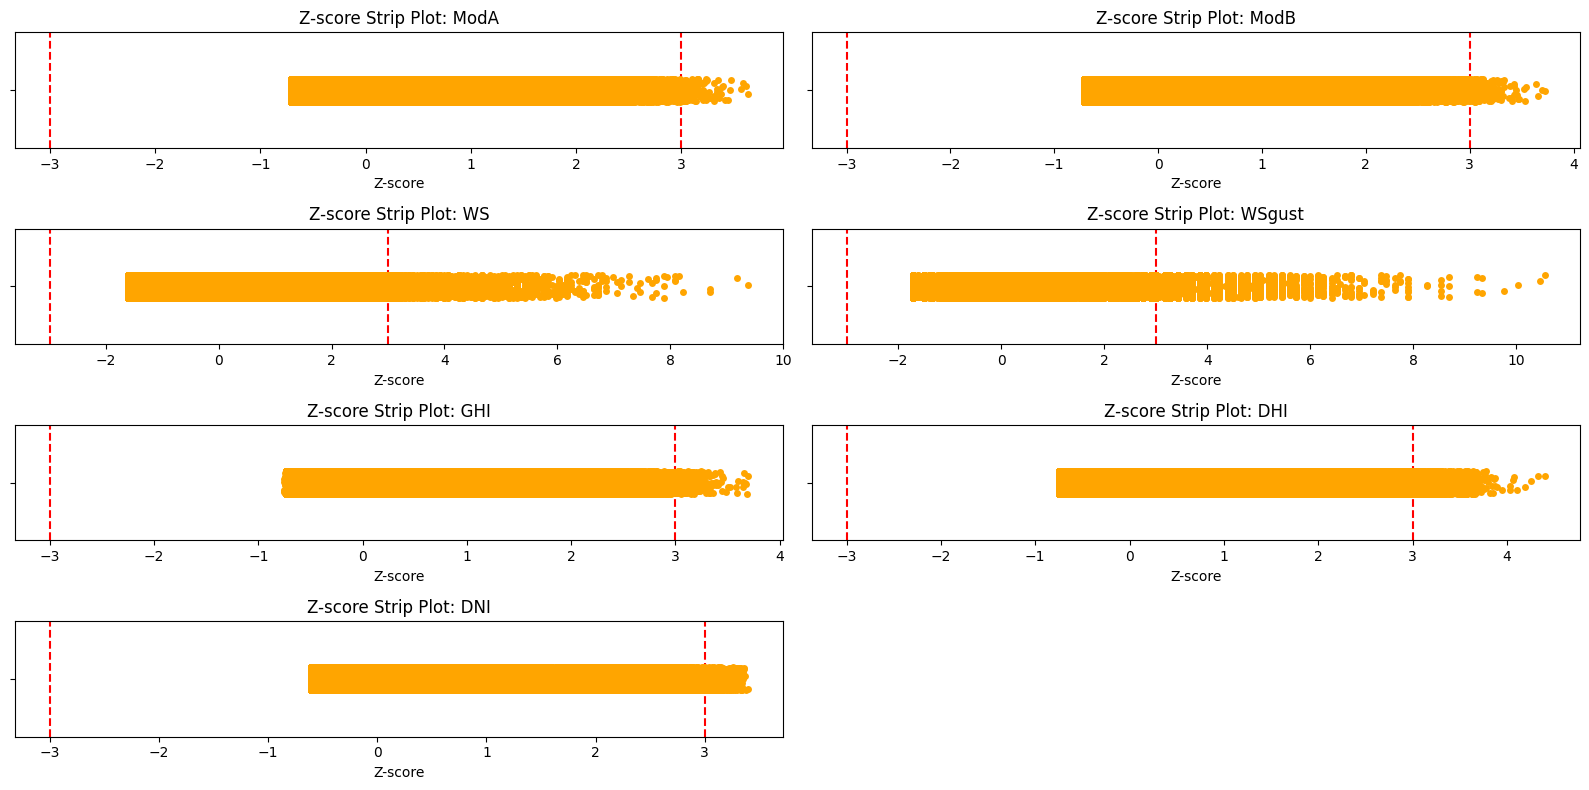

In [29]:
#Z-Score Outlier Strip Plot
plot_outlier_stripplots(df, columns_to_check_for_outliers)

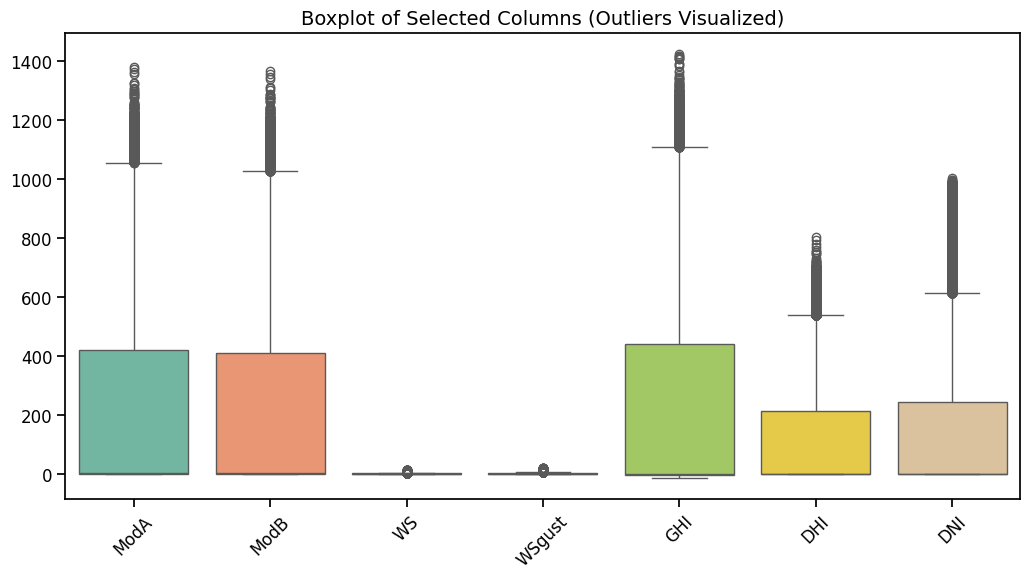

In [30]:

#Visualizing outliers using boxplots
plot_outlier_boxplots(df, columns_to_check_for_outliers)

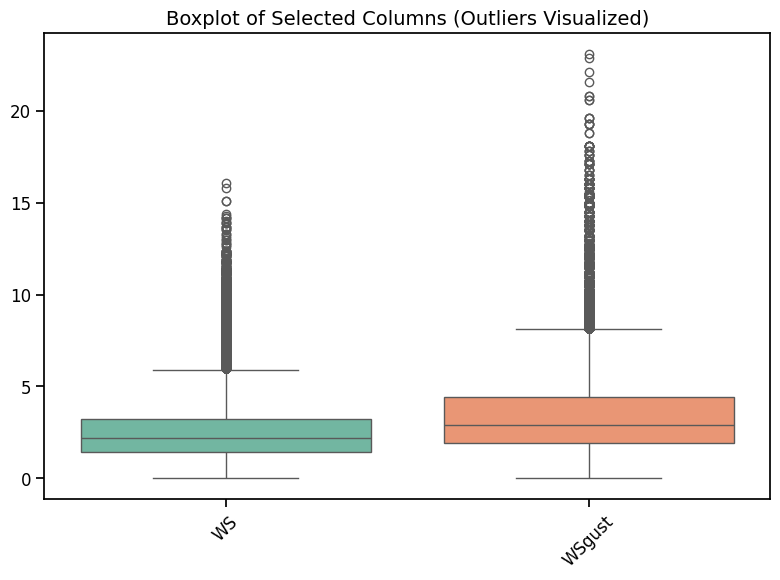

In [31]:
#Singling out WS and WSgust
plot_outlier_boxplots(df, columns_to_check_for_outliers[2:4])

## 🧹 5. Data Cleaning  <a id='5-data-cleaning'></a>

In [32]:
#saving the original dataset for later use
df_original=df.copy()

#### Handle Missing Values

In [33]:
# the comments columns doesn't have any value
columns_to_delete = ['Comments']
existing_columns = [col for col in columns_to_delete if col in df.columns]
df = df.drop(existing_columns, axis=1)

In [34]:
#inspect the data after dropping the columns
df.sample(10)

,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB
500596,2022-10-07 15:17,312.9,81.5,238.5,283.9,283.2,28.4,76.9,2.3,3.4,0.6,25.8,20.2,975,0,0.0,37.7,36.2
94083,2021-12-29 08:04,283.3,230.5,181.1,297.8,285.6,22.2,24.2,3.1,3.9,0.7,76.7,11.4,980,0,0.0,27.1,33.6
277529,2022-05-05 17:30,44.1,0.0,40.6,40.9,39.5,32.4,47.4,4.2,5.2,0.8,209.1,15.6,974,0,0.0,33.6,33.4
200031,2022-03-12 21:52,-3.0,0.0,0.0,0.0,0.0,32.6,37.4,1.0,1.4,0.5,213.0,5.9,974,0,0.0,31.4,31.0
497620,2022-10-05 13:41,852.0,655.8,253.0,850.0,844.0,31.9,63.3,2.4,3.4,0.7,188.0,14.2,975,0,0.0,53.0,53.5
78899,2021-12-18 19:00,-4.7,0.0,0.0,0.0,0.0,26.4,23.8,1.5,1.9,0.4,71.5,5.6,977,0,0.0,24.8,24.4
181075,2022-02-27 17:56,9.8,0.0,13.3,14.4,12.8,35.8,25.7,0.6,1.1,0.6,93.8,5.1,972,0,0.0,35.3,34.9
437994,2022-08-25 03:55,-1.4,0.0,0.0,0.0,0.0,22.6,97.8,0.0,0.7,0.1,230.7,0.0,978,0,0.0,22.3,21.9
380159,2022-07-16 00:00,-0.9,0.0,0.0,0.0,0.0,23.7,93.2,2.4,3.1,0.4,29.2,11.8,977,0,0.0,24.2,24.0
312474,2022-05-29 23:55,-2.1,0.0,0.0,0.0,0.0,28.5,72.4,2.6,3.6,0.6,209.8,14.7,976,0,0.0,28.1,27.6


### Handle Inconsistencies / Inaccuracies

#### Impute zero when all GHI,DHI and DNI are negative during the night

In [35]:
# Impute zero when all GHI,DHI and DNI are negative during the night
conditions = {
    'GHI': '<= 0',
    'DHI': '<= 0',
    'DNI': '<= 0',
    'is_night': '== True'
}

updates = {
    'GHI': 0,
    'DHI': 0,
    'DNI': 0
}
df = conditional_impute(df, 'Timestamp', conditions, updates)

In [36]:
df.sample(10)

,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB
29071,2021-11-14 04:32:00,0.0,0.0,0.0,0.0,0.0,24.4,66.0,2.3,2.9,0.4,223.8,6.5,974,0,0.0,23.3,22.9
339303,2022-06-17 15:04:00,680.3,646.0,192.3,566.2,563.0,31.1,56.9,2.6,3.6,0.9,260.8,15.1,976,0,0.0,48.9,49.2
136930,2022-01-28 02:11:00,0.0,0.0,0.0,0.0,0.0,21.4,24.4,2.7,3.4,0.5,76.0,9.9,976,0,0.0,20.8,20.3
449884,2022-09-02 10:05:00,260.8,0.0,253.8,278.6,276.4,24.7,94.3,3.0,3.6,0.5,226.6,10.1,980,0,0.0,28.9,31.5
84214,2021-12-22 11:35:00,817.0,433.4,445.3,873.0,840.0,30.1,16.8,4.7,6.4,0.8,101.8,15.2,979,0,0.0,43.4,48.9
319062,2022-06-03 13:43:00,784.0,373.0,426.8,721.5,708.0,33.3,36.3,3.5,4.6,0.8,204.5,14.7,974,0,0.0,50.1,51.1
33007,2021-11-16 22:08:00,0.0,0.0,0.0,0.0,0.0,27.0,48.6,2.4,2.6,0.3,215.3,3.7,975,0,0.0,24.9,24.4
71387,2021-12-13 13:48:00,696.6,707.7,177.5,762.6,728.5,36.5,13.2,1.6,2.4,0.4,83.9,15.9,973,0,0.0,49.3,49.6
258401,2022-04-22 10:42:00,923.0,629.9,299.8,857.0,843.0,31.3,63.0,3.0,3.6,0.4,228.5,16.6,975,0,0.0,52.7,63.8
439039,2022-08-25 21:20:00,0.0,0.0,0.0,0.0,0.0,25.3,90.2,1.8,2.6,0.6,266.9,14.0,977,0,0.0,24.5,24.1


In [37]:
#because of the near linear relationship between GHi and MdoA and ModB, we can use regression to impute the 
#negative values of GHI

#Lets set all negative values of GHI,DHI,DNI to NaN
df=replace_negative_irradiance_with_nan(df)
# Impute GHI using ModA and ModB
df =impute_ghi_with_linear_regression(df)
df.sample(10)

,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB
448971,2022-09-01 18:52:00,0.0,0.0,0.0,0.0,0.0,25.8,84.8,0.0,0.0,0.0,0.0,0.0,976,0,0.0,25.3,25.0
175173,2022-02-23 15:34:00,497.1,255.8,340.4,501.9,460.0,37.6,7.1,0.0,0.0,0.0,0.0,0.0,975,0,0.0,47.3,47.3
60868,2021-12-06 06:29:00,30.3,12.0,29.5,32.0,30.8,20.7,30.7,2.2,2.5,0.4,62.7,3.1,977,0,0.0,20.6,20.5
169699,2022-02-19 20:20:00,0.0,0.0,0.0,0.0,0.0,30.3,15.4,1.3,1.6,0.4,78.6,8.5,975,0,0.0,27.9,27.3
321173,2022-06-05 00:54:00,0.0,0.0,0.0,0.0,0.0,28.0,64.8,4.7,5.9,0.7,226.2,14.3,975,0,0.0,27.9,27.6
223571,2022-03-29 06:12:00,14.7,0.0,16.2,16.5,14.6,24.8,15.7,2.1,2.9,0.4,72.9,6.7,975,0,0.0,23.7,23.2
183179,2022-03-01 05:00:00,0.0,0.0,0.0,0.0,0.0,27.8,33.2,1.6,2.1,0.4,171.1,11.3,974,0,0.0,25.6,25.2
222146,2022-03-28 06:27:00,35.6,0.0,35.3,34.5,30.9,28.1,16.7,2.5,3.1,0.5,122.0,13.8,977,0,0.0,27.9,27.5
129382,2022-01-22 20:23:00,0.0,0.0,0.0,0.0,0.0,25.1,11.6,2.8,3.9,0.6,46.6,12.2,979,0,0.0,24.1,23.8
396302,2022-07-27 05:03:00,0.0,0.0,0.0,0.0,0.0,23.9,94.3,2.9,3.9,0.6,217.8,14.4,975,0,0.0,23.8,23.5


In [ ]:
#impute DNI and DHI using other features
# df=impute_multiple_targets_with_model(df)


In [41]:
df.sample(10)

,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB
381955,2022-07-17 05:56:00,14.7,1.7,13.4,15.6,15.4,22.1,94.7,0.0,0.0,0.0,0.0,0.0,978,0,0.0,22.8,22.5
186309,2022-03-03 09:10:00,612.7,515.9,262.9,615.7,597.5,31.2,42.8,2.6,3.1,0.6,217.5,13.1,976,0,0.0,47.4,58.2
463774,2022-09-12 01:35:00,0.0,0.0,0.0,0.0,0.0,21.7,97.3,1.7,1.9,0.3,160.9,12.0,976,0,0.0,22.2,22.0
206565,2022-03-17 10:46:00,727.1,191.6,540.9,707.5,657.2,35.6,32.8,1.6,3.4,1.0,257.5,14.7,975,0,0.0,56.0,60.3
36434,2021-11-19 07:15:00,193.2,291.5,102.0,206.9,198.3,24.9,44.0,0.0,0.0,0.0,0.0,0.0,977,0,0.0,33.0,34.9
422034,2022-08-14 01:55:00,0.0,0.0,0.0,0.0,0.0,24.8,92.0,2.0,2.9,0.5,225.3,9.2,975,0,0.0,24.4,24.1
63983,2021-12-08 10:24:00,798.6,747.4,227.2,888.9,846.0,32.7,14.8,3.4,4.6,0.7,118.3,13.4,979,0,0.0,45.5,50.6
210773,2022-03-20 08:54:00,511.9,196.7,370.9,482.3,436.5,29.6,53.6,2.6,3.6,0.6,221.5,9.5,976,0,0.0,43.2,49.0
354635,2022-06-28 06:36:00,115.2,171.7,74.3,68.5,67.6,26.1,85.8,2.1,2.9,0.4,243.4,11.3,978,0,0.0,29.6,29.8
443696,2022-08-29 02:57:00,0.0,0.0,0.0,0.0,0.0,23.3,96.9,0.5,1.1,0.5,214.3,8.4,977,0,0.0,23.6,23.2


In [42]:
#count of missing values per column
df.isna().sum() 

Timestamp        0
GHI              0
DNI              0
DHI              0
ModA             0
ModB             0
Tamb             0
RH               0
WS               0
WSgust           0
WSstdev          0
WD               0
WDstdev          0
BP               0
Cleaning         0
Precipitation    0
TModA            0
TModB            0
dtype: int64

## 📈 6. Univariate Analysis (Single Variable) <a id='Univariate Analysis (Single Variable)'></a>

### Distributions of Variables

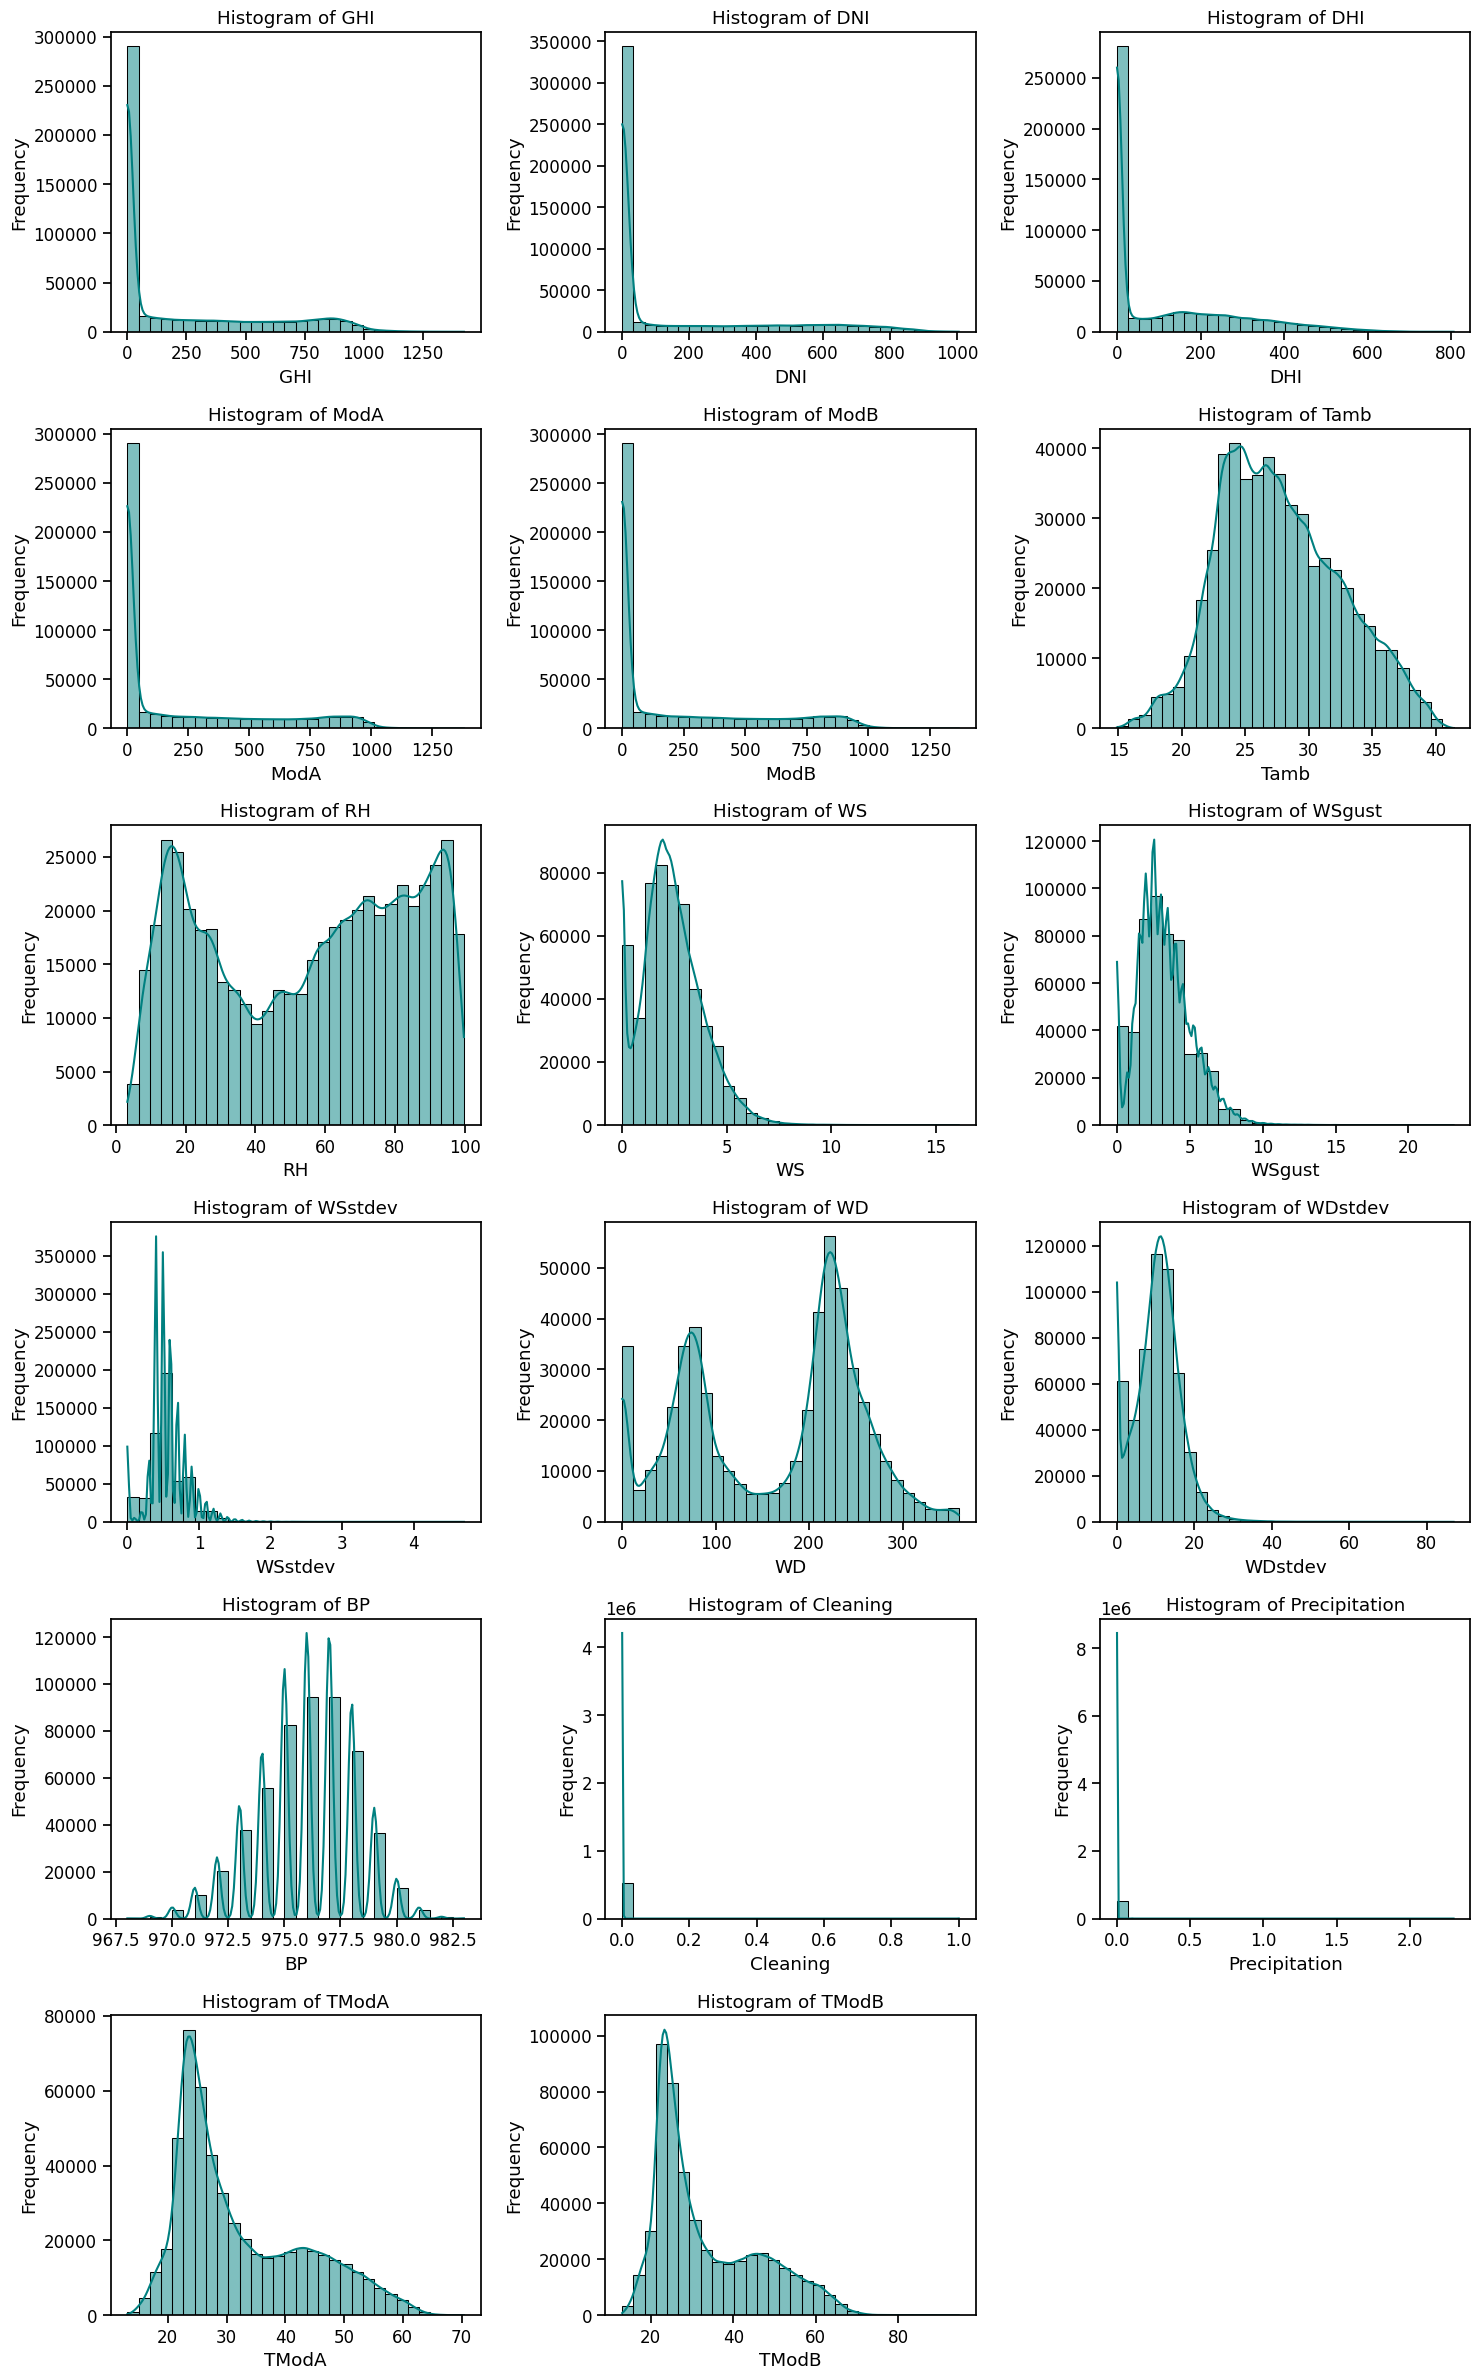

In [43]:
#plot histograms for continuous variables
plot_continuous_histograms(df)

## 📉 7. Bivariate/Multivariate Analysis <a id='7-bivariatemultivariate-analysis'>

### Correlation & Relationship Analysis

In [ ]:
columns=df.columns.to_list()
columns

In [ ]:
# Pairplot of selected columns
columns_for_pairplot = [*columns_to_check_for_outliers, 'Tamb', 'RH', 'BP', 'Precipitation', 'TModA', 'TModB', 'WD']
plot_pairplot(df, columns_for_pairplot)

#### Heatmap of correlations (GHI, DNI, DHI, TModA, TModB).

In [ ]:
columns = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB']
plot_correlation_heatmap(df,columns)

#### Scatter plots: WS, WSgust, WD vs. GHI; RH vs. Tamb or RH vs. GHI.


In [ ]:
plot_scatter_relationships(df)

#### Wind & Distribution Analysis

In [ ]:
plot_wind_rose(df)

### Temperature Analysis

In [ ]:
#Examine how relative humidity (RH) might influence temperature readings and solar radiation
plot_rh_relationships(df)

#### Bubble Chart

In [ ]:
#GHI vs. Tamb with bubble size = RH or BP.
plot_bubble_ghi_vs_tamb(df)

### Cleaning Effect

In [ ]:
# Group by 'Cleaning' and calculate mean for ModA and ModB
plot_mod_cleaning_effect(df)

## 🧮 Feature Engineering <a id='8-feature-engineering'><a>

#### GHI,DNI,DHI,ModA and ModB  have skewed distribution - transforming them to normal distribution will help in case we choose to use parametric tests later

In [ ]:
#log transform the columns GHI, DNI, DHI, ModA and ModB
df=log_transform_columns(df, ['GHI', 'DNI', 'DHI', 'ModA', 'ModB'])

In [ ]:
# recheck the distributions after log transformation
plot_continuous_histograms(df)

## 📅 9. Time Series Trends  <a id='9-time-series-trends'></a>

#### Line or bar charts of GHI, DNI, DHI, Tamb vs. Timestamp.

In [ ]:
plot_irradiance_temperature_timeseries(df_original)

#### Observe patterns by month, trends throughout day, or anomalies, such as peaks in solar irradiance or temperature fluctuations. 

##### 🔍 1. Monthly Patterns

In [ ]:
# Extract month from timestamp
plot_monthly_irradiance_temperature(df_original)

#### 🕒 2. Daily Trends

In [ ]:
#plot average daily patter of irradiance and temperature by hour
plot_hourly_irradiance_temperature(df)

In [ ]:
#filter out daytime measurements
day_df=filter_daytime(df)

In [ ]:
#plot distribution of measurements for daytime data
plot_continuous_histograms(day_df)

##### ⚠️ 3. Anomaly Detection (Peaks & Drops)

In [ ]:
plot_ghi_anomalies(df)

#### Save the preprocessed dataset

In [ ]:
#### Save the preprocessed dataset
df.to_csv('../data/togo-dapaong', index=False)


## 🧠 10. Key Insights <a id='10-key-insights'></a>

<div style="border-radius:10px; border:orange solid; padding: 15px; font-size:100%; text-align:left; font-color:#325939;background-color:#2c2c2c">
<h3 align="left"><font color='orange'>💡 Observations:</font></h3>

* There is near-linear relationship between WS (Wind Speed) and WSgust (Wind Gust Speed): In the context of the project — analyzing solar energy potential and sensor performance — it might be redundant to include both WS (Wind Speed) and WSgust (Wind Gust)
* There is a near linear relationship between GHI and both ModA and ModB
* There is a near linear relationship between ModA and ModB
* WD has little correlation with any of the other variables
* There is a linear relationship between TModA and TModB and their correlation with all other variables is near identical
</div>

<div style="border-radius:10px; border:orange solid; padding: 15px; font-size:100%; text-align:left; font-color:#325939;background-color:#2c2c2c">
<h3 align="left"><font color='orange'>💡 Observations:</font></h3>

**☀️ Solar Irradiance Variables (GHI, DNI, DHI, ModA, ModB)**
Distributions are right-skewed: Most values are close to zero, with a long tail of high values.

**Implication:** These are only non-zero during daytime → confirms irradiance-based splitting logic (e.g., GHI > 0 → daytime).

**Action:** There might be a need to  apply log transformation or clipping when using them for modeling or visualization.
</div>

<div style="border-radius:10px; border:orange solid; padding: 15px; font-size:100%; text-align:left; font-color:#325939;background-color:#2c2c2c">
<h3 align="left"><font color='orange'>💡 Observations:</font></h3>

**💧 Humidity (RH)**
Fairly uniform or slightly U-shaped: High frequency at both low and high RH levels.

**Implication:** Reflects variability in atmospheric moisture (from dry to humid).

**Action:** RH can be a good input to model heat dissipation or fog effects on panels.
</div>

<div style="border-radius:10px; border:orange solid; padding: 15px; font-size:100%; text-align:left; font-color:#325939;background-color:#2c2c2c">
<h3 align="left"><font color='orange'>💡 Observations:</font></h3>

**🧪 BP (Barometric Pressure)**
Shows cyclical fluctuations (possibly measurement artifact or elevation-influenced).

**Implication:** Limited predictive power unless used in atmospheric modeling.

**Optional:** Could be dropped if irrelevant for power forecasting.
</div>

## 🔚 11. Conclusion & Next Steps <a id='11-conclusion--next-steps'></a>

<div style="border-radius:10px; border:orange solid; padding: 15px; font-size:100%; text-align:left; font-color:#325939;background-color:#2c2c2c">
<h3 align="left"><font color='orange'>💡 Recommendations:</font></h3>

* Given the strong correlations among solar variables (GHI, DNI, DHI, ModA, ModB), consider dimensionality reduction (e.g., PCA) or selecting a subset to avoid multicollinearity in modeling.
* Temperature and humidity variables are moderately correlated with solar irradiance, so including both can help models capture environmental conditions affecting your system.
* Log-transforming skewed variables like solar irradiance and wind speeds could improve model performance by normalizing their distributions.
* Variables like Cleaning and Precipitation are mostly zeros. Ensure models handle this class imbalance properly or use specialized techniques for rare events.
* Consider interaction terms between solar radiation and humidity or temperature, as their interplay may affect your system’s behavior.
</div>